In [1]:
import numpy as np
import matplotlib
#allow for latex markup in matplotlib figures
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap


#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../polling_systems")
sys.path.insert(0, "../geometry")
sys.path.insert(0, "../path_planning_prob")
sys.path.insert(0, "../utils")

#path planning prob
from path_planning_problem import PathPlanningProblem
from goal_region import GoalRegion

#So we can import my local libs
import CommChannel as CC
import qos
from importlib import reload 

import pointcloud as PC
from obstacles import ObstacleMod, PolyObstacle, AccelerationCap, SpectralEfficiencyCap

CGAL not installed. Will be unable to automactically partition.
triangle not installed. Will be unable to automactically partition.


In [2]:
#setup quality of service requirements using reasonable values
F5GHz, F2_4GHz = 5, 2.4 #typical wifi frequencies are 2.4, 5, and sometiems 6 GHz
MOBILE_TX_POWER = qos.Pwr(20)#100-200mW (20-23 dBm) pretty typical, with 1W (30dBm) the absolute maximum
print(MOBILE_TX_POWER)
r = 6#any of 2, 4, 6, or 8
bandwidth = 2#leave bandwidth in MHz*1000000#give ourselfes 2MHz of BW
rx_noise = qos.Pwr(-85)#based on Yan and MostofiTWC13 #1e-10#
print(rx_noise)
BER = 1e-6
GAMMA_TH = qos.QoSReq(BER, r, rx_noise).thresholdChannelGain(MOBILE_TX_POWER)
print(GAMMA_TH)
print('SNR Threshold: %d'%(GAMMA_TH+MOBILE_TX_POWER.dBm - rx_noise.dBm))

20.000000 dBm	-10.000000 dBW	100.000000 mW	0.100000 W
-85.000000 dBm	-115.000000 dBW	0.000000 mW	0.000000 W
-77.90174759231485
SNR Threshold: 27


In [18]:
reload(CC)
#generate a single, simple channel
#Setup the communication environment:

#For now, use same channel params
nPL = 5.2
kPL = -20

decorrSH = 2.09  
alpha = 30
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1.75

qBase = [2,3]

x_max = 20
x_min = 0
y_max = 20
y_min = 0
v_max = 8
v_min = -8
data = 40000#kb 40mb

a_max = 3
r_max = 8
region = [x_max, x_min, y_max, y_min]


cp = CC.ChannelParams(qBase, nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP)


#res = 2/decorrMP
res = 10
p_th = 0.5
#create the true channel
true_channel = CC.CommChannel(cp, region, res)
true_channel.generateSH();true_channel.generateMP(2)
BW = 1.5#2KHz


pct_sample = 0.01#1% sampling
n_samples = int(pct_sample*(region[0] - region[1])*(region[2] - region[3])*res**2)
print('Drawing %d samples'%(n_samples))
xs, vals = true_channel.sampleChannel(n_samples)
pred_channel = CC.PredictedChannel(cp, region, res, xs, vals)
pred_channel.setPth(p_th)

Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Drawing 400 samples


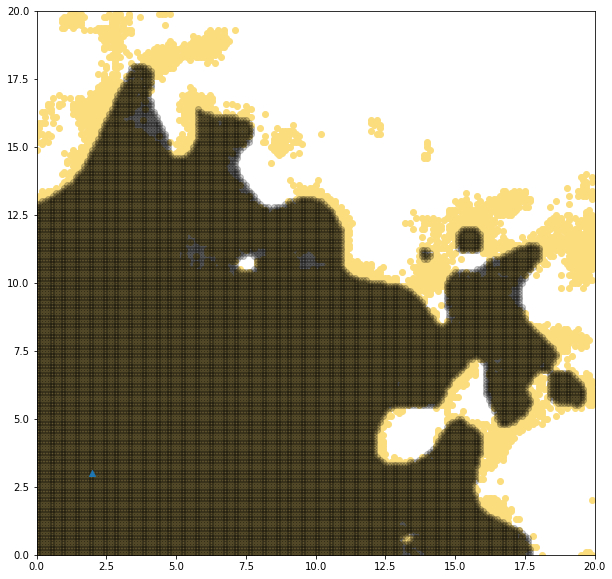

In [19]:
cc = true_channel
pc = pred_channel
gamma_th = GAMMA_TH
fig = plt.figure(figsize=(10,10))
true_points = cc.getConnectedPoints(gamma_th)
plt.scatter(true_points[:,0], true_points[:,1], color='xkcd:wheat')
pred_points = pc.getConnectedPoints(gamma_th)
plt.scatter(pred_points[:,0], pred_points[:,1], color='k', alpha=0.2)
plt.xlim((cc.region[1], cc.region[0]))
plt.ylim((cc.region[3], cc.region[2]))
plt.scatter([qBase[0]], [qBase[1]], marker='^')

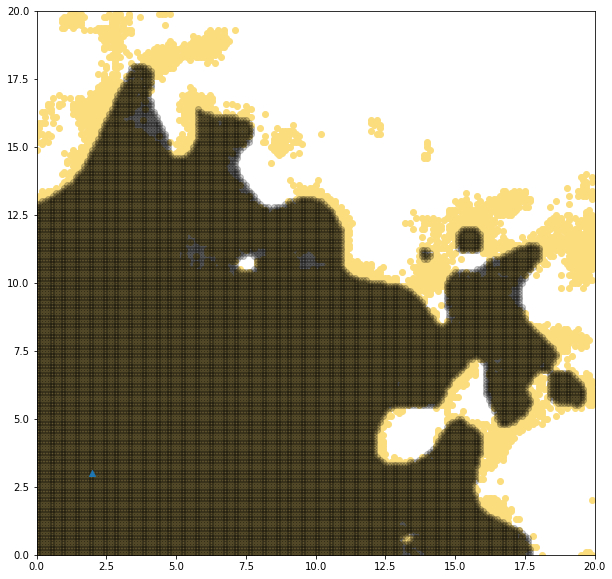

In [20]:
fig = plt.figure(figsize=(10,10))
plt.scatter(true_points[:,0], true_points[:,1], color='xkcd:wheat')
plt.scatter(pred_points[:,0], pred_points[:,1], color='k', alpha=0.2)
plt.xlim((cc.region[1], cc.region[0]))
plt.ylim((cc.region[3], cc.region[2]))
plt.scatter([qBase[0]], [qBase[1]], marker='^')

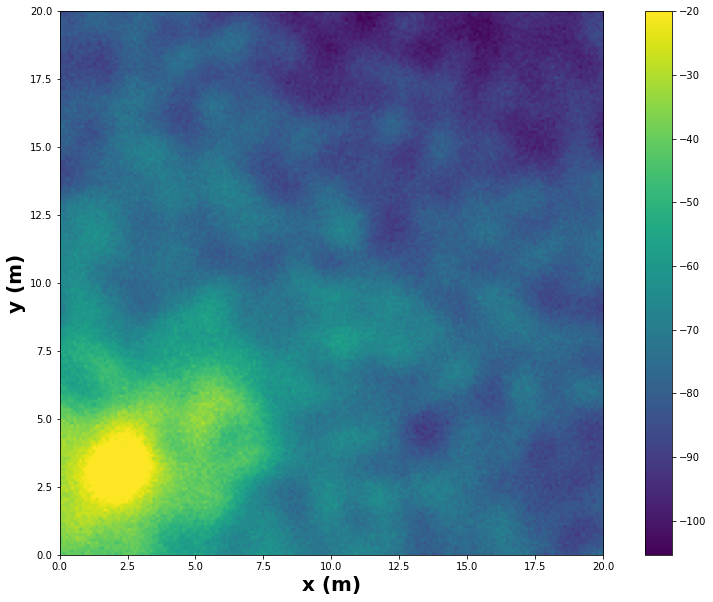

In [21]:
#first, just work with the true channel
cc.plot_channel(twod=True)

In [22]:
from motion import LinearMotionPower
from misc import split_seg_by_time
from qos import QoSReq
def energy(n1, n2, channel, BW, k1, k2, ber, rx_noise):
    #calculate motion energy
    x1 = n1.x; x2 = n2.x;
    dist = np.linalg.norm(x1[:2] - x2[:2])
    v_avg = np.linalg.norm(x1[2:4] + x2[2:4])/2
    time = dist/v_avg
    a = np.linalg.norm(x1[2:4] - x2[2:4])/time
    motion_energy = LinearMotionPower(k1, k2, v_avg)*time
    
    #calculate comm energy
    r = (x1[4] - x2[4])/(time*BW)
    comm_energy = 0
    if r>0:
        qos = QoSReq(ber, r, rx_noise)
        dt = 0.1
        path = split_seg_by_time(x1[:2], x2[:2], x1[2:4], x2[2:4], time, dt=dt)
        pl = len(path)

        for i in range(1,pl):
            txPower_s = channel.getReqTXPowerAtPoint(path[i-1], qos)
            txPower_f = channel.getReqTXPowerAtPoint(path[i], qos)
            #then look at the power in watts
            comm_energy += (txPower_s+txPower_f).W*dt/2

    return motion_energy + comm_energy
        



In [23]:
import obstacles as OB
reload(OB)
source = np.array([0,18, 0, 0, data])
dests = np.array([[18,0, 0, 0, 0]])

goal_region = PC.PointCloud(dests)
goal_region.polygons = [PC.Poly(np.array([[18.5, 0.5],[18.5, -0.5],[17.5, -0.5],[17.5, 0.5]]))]
obstacle_mod = ObstacleMod([OB.PolyObstacle(np.array([[12,10],[9,7],[12,7]])),
                           OB.SpectralEfficiencyCap(r_max, BW),
                          OB.AccelerationCap(a_max)])
#cost_func= lambda n1, n2: np.linalg.norm(n1.x - n2.x)
k1 = 7.2; k2 = 0.29
cost_func = lambda n1, n2: energy(n1, n2, cc, BW, k1, k2, BER, rx_noise)

In [24]:
problem_region = [*region, v_max, v_min, v_max, v_min, data, 0]
pppi = PathPlanningProblem(problem_region, source, GoalRegion(goal_region), obstacle_mod, cost_func)

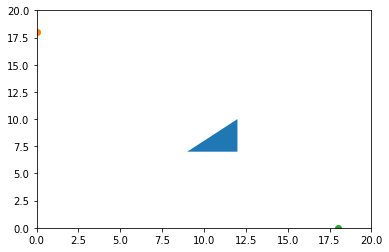

In [25]:
pppi.plotProb()

In [26]:
sys.path.insert(0, "../rrt")
import rd_tree as RDT
from sampler import SamplerType, Sampler
from stop_criteria import StopCriteria
reload(RDT)
mins = 30
seconds = mins*60
stop = StopCriteria(solution_required = True, max_run_time=seconds)
smplr = Sampler(SamplerType.UNIRAND, 30)
do_rewire = True
steer_rad = 3
solver = RDT.RDTSolver(smplr, stop, do_rewire, steer_rad)

../rrt\rd_tree.py:95: RuntimeWarning: invalid value encountered in double_scalars
  gamma = (2*(1+1/d)*(lb_ms/lb_unit_ball))**(1/d) + 1#need to make it greater
../path_planning_prob\obstacles.py:190: RuntimeWarning: divide by zero encountered in double_scalars
  time = 2*dist/np.linalg.norm(v1+v2) #assume linear, constant acceleration
../path_planning_prob\obstacles.py:169: RuntimeWarning: divide by zero encountered in double_scalars
  time = 2*dist/np.linalg.norm(v1+v2) #assume linear, constant acceleration
../rrt\rd_tree.py:238: RuntimeWarning: invalid value encountered in less
  radius = min(self.steerRad, self.gamma*np.sqrt(np.log(cardV)/cardV))
C:\Users\wdurh\Documents\research\comm aware robotics\Code\python\rrt\../geometry\CoordTransforms.py:70: UserWarning: Some points are outside of the region
  warnings.warn('Some points are outside of the region')


Iteration count: 100


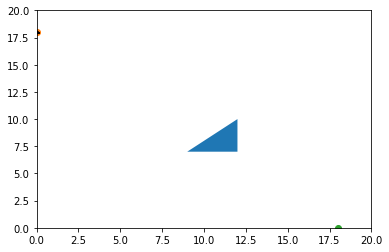

../rrt\rd_tree.py:238: RuntimeWarning: invalid value encountered in less
  radius = min(self.steerRad, self.gamma*np.sqrt(np.log(cardV)/cardV))
C:\Users\wdurh\Documents\research\comm aware robotics\Code\python\rrt\../geometry\CoordTransforms.py:70: UserWarning: Some points are outside of the region
  warnings.warn('Some points are outside of the region')


Iteration count: 1000


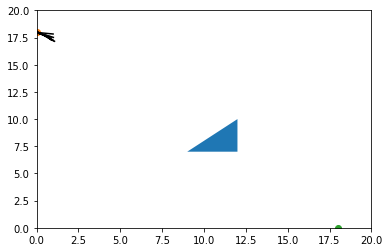

../rrt\rd_tree.py:238: RuntimeWarning: invalid value encountered in less
  radius = min(self.steerRad, self.gamma*np.sqrt(np.log(cardV)/cardV))


Iteration count: 2000


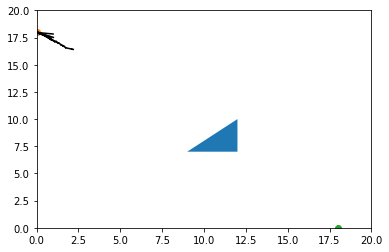

../rrt\rd_tree.py:238: RuntimeWarning: invalid value encountered in less
  radius = min(self.steerRad, self.gamma*np.sqrt(np.log(cardV)/cardV))
C:\Users\wdurh\Documents\research\comm aware robotics\Code\python\rrt\../geometry\CoordTransforms.py:70: UserWarning: Some points are outside of the region
  warnings.warn('Some points are outside of the region')


Iteration count: 5000


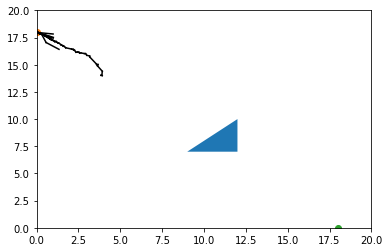

../rrt\rd_tree.py:238: RuntimeWarning: invalid value encountered in less
  radius = min(self.steerRad, self.gamma*np.sqrt(np.log(cardV)/cardV))
C:\Users\wdurh\Documents\research\comm aware robotics\Code\python\rrt\../geometry\CoordTransforms.py:70: UserWarning: Some points are outside of the region
  warnings.warn('Some points are outside of the region')


In [ ]:
solver.solve(pppi)

In [ ]:
root = solver.getRoot()
bsf = solver.getBSF()
root.plotTree(style='k-')
bsf.pathToRoot(do_plot=True)
pppi.plotProb()

In [ ]:
print(bsf)

In [ ]:
#OK now let's figure out a good way to plot this
path = bsf.pathToRoot()

In [ ]:
cc.plot_channel(twod=True)
pppi.plotProb()

vs = np.linalg.norm(path[:,2:4], axis=1)
x = path[:,0]
y = path[:,1]
n = len(path)
base_width=10
for i in range(n-1):
    plt.plot(x[i:i+2], y[i:i+2], 'k', linewidth = 10/(1+vs[i]+vs[i+1]))

In [ ]:
vs = path[:,2:4]
